# Autoregressive models using a feedforward neural network 
## PART 2: Applying the methods to health care time series

In this notebook we will use a feedforward neural network to fit a single and ensemble linear and non-linear models to real time series data. 

<div class="alert alert-info">
    
1. Most of the work we will do is data manipulation: preprocessing data and making sure it is the right shape for the neural networks.

2. The ensemble learning method can be computationally expensive.  We have included some pre-trained models that can be loaded from file if your machine is not powerful or you cannot use Google Collabratory.
</div>

---
**LEARNING OBJECTIVES**

* Learn how to apply feedforward neural networks to real health data.
* Methods to preprocess nn input data.
* Recognise the stochastic nature of neural network training
* Use a ensemble of neural networks to provide a more reliable point forecast
---


## 1. Python dependencies

It is recommended that you use the forecasting course conda environment provided. We are again going to implement neural networks using `tensorflow` and '`keras`. You should be using at least `tensorflow` version `2.1.0`.

In [2]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#tensorflow imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping

from statsmodels.tools.eval_measures import rmse


tf.__version__

'2.1.0'

## 2. Forecasting emergency admissions in England

We will now use feedforward neural networks to predict the number of monthly emergency admissions in England. 

### 2.1 Load the data

**Task**:
* Execute the code below to read the emergency admissions data into pandas

In [3]:
url = 'https://raw.githubusercontent.com/health-data-science-OR/data/master/em_admits_ts.csv'
em_admits = pd.read_csv(url)

In [479]:
em_admits.head(3)

,month_year,em_admits
0,Aug-10,425702
1,Sep-10,424900
2,Oct-10,436215


In [4]:
em_admits.shape

(111, 2)

## 2.3. Preprocessing 

### 2.3.1 Datetime format (**optional section**)

Notice the the `month_year` column holds a string an odd date format e.g. 'Aug-10'.  Pandas cannot cope with this as-is because '10' could refer to any century!  So let's do a bit of preprocessing to get it into datetime format.


*Optional Task:*
* Take some time to understand the code that preprocesses the dates.  This is real health data and it is likely you will need to deal with formatting issues as experienced here.

First we will format the string to something pandas can parse i.e. 'Aug 2010'.  Then we will call the `pd.to_datetime()` function to parse the string and return a `datetime`.  We will assign the result to our dataframe's index and set the freq to monthly start 'MS'

In [9]:
date_str = em_admits['month_year'].str[:3] + ' 20' + em_admits['month_year'].str[-2:]
date_str.name = 'date'
em_admits = em_admits.set_index(pd.to_datetime(date_str))
em_admits.index.freq = 'MS'
em_admits = em_admits.drop(columns=['month_year'])

In [10]:
em_admits.head()

,em_admits
date,
2010-08-01,425702
2010-09-01,424900
2010-10-01,436215
2010-11-01,429099
2010-12-01,452728


### 2.3.2 Visualise the training data

We will be forecasting the last 12 months of the series.  Let's take a look at the training data (being careful to exclude the last 12 months)

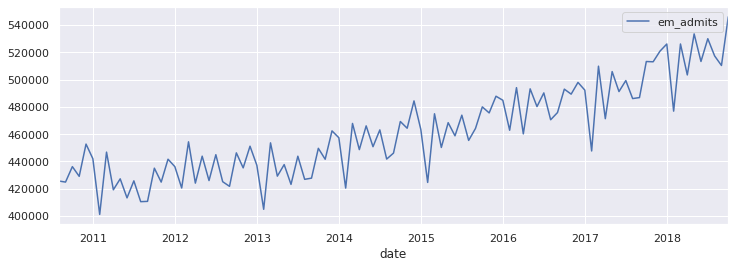

In [11]:
holdout_length = 12
em_admits[:len(em_admits)-holdout_length].plot(figsize=(12,4));

### 2.3.2 Calender adjustment

This is monthly data so a useful preprocessing step is to transform the data into a daily rate by dividing by the number of days in the month. When we plot this the troughs we saw in Feb each year disappear.

Task:
* Calculate the average admissions per day series
* Plot the training data (holding back 12 months for testing)

In [12]:
admit_rate = em_admits['em_admits'] / em_admits.index.days_in_month

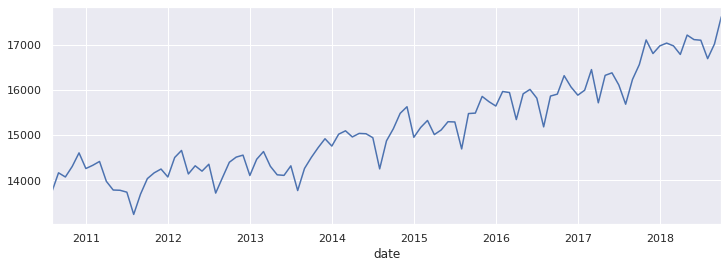

In [13]:
admit_rate[:len(admit_rate)-12].plot(figsize=(12,4));

### 2.3.3 Convert the time series to format suitable for supervised learning.

Task:
* Using a sliding window approach convert the time series into a tabular format. 
 * Use a window size of 12 and assume you are predicting a scalar value of y (1-step ahead).
* Conduct a train test split holding back 12 windows for test.

In [14]:
def sliding_window(train, window_size=2, horizon=1):
    '''
    sliding window.
    
    Parameters:
    --------
    train: array-like
        training data for time series method
    
    window_size: int, optional (default=2)
        lookback - how much lagged data to include.
        
    horizon: int, optional (default=1)
        number of observations ahead to predict
            
    Returns:
        array-like, array-like
    
        preprocessed X, preprocessed Y
    '''
    tabular_X = []
    tabular_y = []
    
    for i in range(0, len(train) - window_size - horizon):
        X_train = train[i:window_size+i]
        y_train = train[i+window_size+horizon-1]
        tabular_X.append(X_train)
        tabular_y.append(y_train)
       
    return np.asarray(tabular_X), np.asarray(tabular_y).reshape(-1, )

In [15]:
X_train, y_train = sliding_window(admit_rate, window_size=12)

In [16]:
test_length = 12
X_train, y_train = X_train[:len(X_train) - 12], y_train[:len(X_train) - 12]
X_test, y_test = X_train[len(X_train) - 12:], y_train[len(X_train) - 12:]

### 2.3.4 Scaling the features and target to be between -1 and 1

In lot's of machine learning applications data are scaled to be between 0 and 1.  For neural network forecasting, *Ord, Fildes and Kourentzes* recommend scaling to be between -1 and 1.  This is what we will do here.  To do the scaling we will use

```python
sklearn.preprocessing.MinMaxScaler
```

Task:
* Execute the code below to transform the data.

**TO ADD: short video of how min max scaler works**

In [18]:
from sklearn.preprocessing import MinMaxScaler

In [19]:
scaler = MinMaxScaler(feature_range=(-1, 1))

In [20]:
#I am scaling on admit_rate because this will include the first 12 lags 
#not in y_train
scaler.fit(admit_rate.iloc[:-12].to_numpy().reshape(-1, 1))

MinMaxScaler(feature_range=(-1, 1))

In [21]:
y_train = scaler.transform(y_train.reshape(-1, 1))
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
y_test = scaler.transform(y_test.reshape(-1, 1))

## 2.4 A Linear model benchmark

The first model we will try is the linear model. Its will serve as our neural network baseline.  (In practice we would also check this is better than a naive method).

### 2.4.1. Train the model

Task:
* Using `Keras`, construct a neural network that mimics a simple linear regression model (see previous notebook).  
* Optional: To get comparable results, set the tensorflow random number seed to 1234
* Train the model for 100 epochs.
* Optionally you can use an early stopping callback.

In [23]:
def get_linear_model(ws, lr=0.01, metrics=None):
    if metrics is None:
        metrics = ['mae', 'mse']
    
    model = Sequential([Dense(1, input_shape=(ws,))])
    model.compile(loss='mse', 
                  optimizer=Adam(lr=lr),
                  metrics=metrics)
    
    return model

In [24]:
#set tensorflow random seed for repeatability
tf.random.set_seed(1234)

N_EPOCHS = 100
es = EarlyStopping(monitor='val_loss', patience=10)

#call the linear model function create earlier.
model_lm = get_linear_model(ws=12, metrics=['mae'])

#fit model silently (verbose=0)
history = model_lm.fit(x=X_train, 
                    y=y_train, 
                    epochs=N_EPOCHS,
                    validation_data=(X_test, y_test),
                    verbose=0,
                    callbacks=[es])

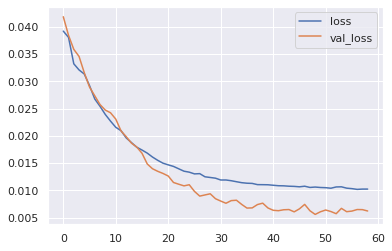

In [25]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

### 2.4.2 Plot the fitted values

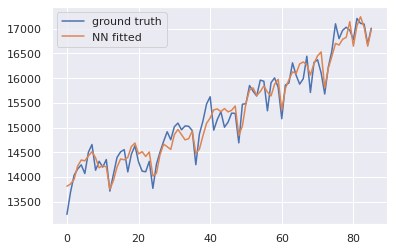

In [26]:
plt.plot(scaler.inverse_transform(y_train), label='ground truth')
plt.plot(scaler.inverse_transform(model_lm.predict(X_train)), label='NN fitted')
plt.legend();

### 2.4.3 Generate and evaluate a multi-step forecast

Task:
* Using the iterative method produce a 12 step forecast. Save the predictions in a variable called `y_preds_lm`
* Plot the results: predictions versus test
* Calculate the RMSE

In [29]:
def autoregressive_iterative_forecast(model, exog, h):
    '''
    h-step forecast for an autoregressive 
    model using the iterative prediction method.
    
    Conduct h one-step forecasts gradually
    replacing ground truth autoregressive X 
    values with predictions.
    
    Parameters:
    ------
    model: forecast object
        model that has a .predict(h) interface
        
    exog: array-like
        initial vector of lagged values (X)
    
    h: int
        forecast horizon. assumed to be > 0
    
    Returns:
    ------
    numpy.ndarray
        y_predictions
    '''
    y_preds = []
    current_X = exog
    for i in range(h):
        y_pred = model.predict(current_X.reshape(1, -1), 
                               use_multiprocessing=True)[0,0]
        y_preds.append(y_pred)

        current_X = np.roll(current_X, shift=-1)
        current_X[-1] = y_pred

    return np.array(y_preds)

In [30]:
def plot_nn_prediction_results(model, X_train, y_train, y_test, y_preds):  
    
    #create series
    fitted_values = scaler.inverse_transform(model.predict(X_train))
    ground_truth = scaler.inverse_transform(y_train)
    ground_truth_val = scaler.inverse_transform(y_test)

    padding = np.full(len(fitted_values), np.NAN)

    validation = np.concatenate([padding.reshape(-1, 1), ground_truth_val])
    forecast = np.concatenate([padding.reshape(-1, 1), y_preds])

    plt.plot(ground_truth, label='ground truth')
    plt.plot(validation, label='test')
    plt.plot(fitted_values, label='in-sample', linestyle='-.')
    plt.plot(forecast, label='out-of-sample', linestyle='-.')
    plt.legend();

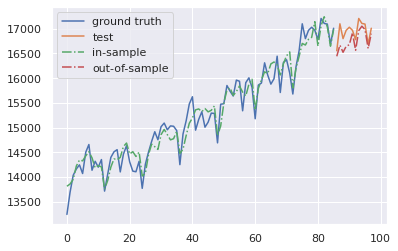

In [32]:
#predict next 12 months and plot
H = 12
y_preds_lm = autoregressive_iterative_forecast(model_lm, X_test[0], h=H)
y_preds_lm = scaler.inverse_transform(y_preds_lm.reshape(-1, 1))

plot_nn_prediction_results(model_lm, X_train, y_train, y_test, y_preds_lm)

In [43]:
rmse(y_preds_lm, scaler.inverse_transform(y_test))[0]

232.64619857435963

## 2.5 Training a non-linear network

Task 
* Introduce a hidden layer(s) to your neural network.  Use a ReLU activation function.

In [248]:
def get_network_model(ws, n_neurons_l1=32, n_neurons_l2=64,
                      include_layer_two=False, 
                      lr=0.01, metrics=None):
    if metrics is None:
        metrics = ['mse']
        
    model = Sequential()
    model.add(Flatten(input_shape=(ws,)))
    model.add(Dense(n_neurons_l1, activation='relu'))
    if include_layer_two:
        model.add(Dense(n_neurons_l2, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', 
                  optimizer=Adam(lr=lr),
                  metrics=metrics)
    return model

In [285]:
#set tensorflow random seed
tf.random.set_seed(45676)

N_EPOCHS = 100
es = EarlyStopping(monitor='loss', patience=10)

#single layer nn
mlp = get_network_model(ws=12, n_neurons_l1=32)

#fit model silently
history = mlp.fit(x=X_train, 
                    y=y_train, 
                    epochs=N_EPOCHS,
                    verbose=0, callbacks=[es])

rmse lm: 232.65
rmse mlp: 98.50


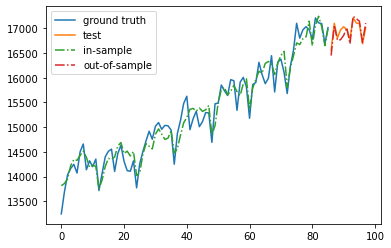

In [287]:
#predict next 12 months and plot
H = 12
y_preds_mlp = autoregressive_iterative_forecast(mlp, X_test[0], h=H)
y_preds_mlp = scaler.inverse_transform(y_preds_mlp.reshape(-1, 1))

plot_nn_prediction_results(model, X_train, y_train, y_test, y_preds_mlp)

rmse_lm = rmse(scaler.inverse_transform(y_test), y_preds_lm)[0]
rmse_mlp = rmse(scaler.inverse_transform(y_test), y_preds_mlp)[0]

print(f'rmse lm: {rmse_lm:.2f}\nrmse mlp: {rmse_mlp:.2f}')

rmse lm: 232.65
rmse mlp: 63.90


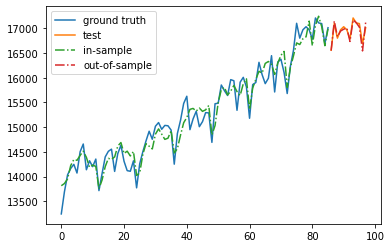

In [293]:
#try changing the network parameters to see the impact on the 
#rmse relative to the linear model

#set tensorflow random seed
tf.random.set_seed(45676)

N_EPOCHS = 100
H = 12
es = EarlyStopping(monitor='loss', patience=10)

#single layer nn
mlp = get_network_model(ws=12, 
                        n_neurons_l1=32,
                        include_layer_two=True,
                        n_neurons_l2=64,
                        lr=0.01)

#fit model silently
history = mlp.fit(x=X_train, 
                    y=y_train, 
                    epochs=N_EPOCHS,
                    verbose=0, callbacks=[es])

y_preds_mlp = autoregressive_iterative_forecast(mlp, X_test[0], h=H)
y_preds_mlp = scaler.inverse_transform(y_preds_mlp.reshape(-1, 1))

rmse_lm = rmse(scaler.inverse_transform(y_test), y_preds_lm)[0]
rmse_mlp = rmse(scaler.inverse_transform(y_test), y_preds_mlp)[0]

print(f'rmse lm: {rmse_lm:.2f}\nrmse mlp: {rmse_mlp:.2f}')

plot_nn_prediction_results(model, X_train, y_train, y_test, y_preds_mlp)

# Ensemble Learning

In all of the examples above we have been setting a random seed for tensorflow.  This 'suggests' that if we used a different randon number seed we would get a slightly different result.  One of the problems with neural networks is overfitting.  There are multiple ways to deal with overfitting.  In forecasting a common approach is to use an **ensemble** of models.  

In an ensemble we train multiple models. 

## Training an ensemble

We will train an ensemble of neural networks that mimic a linear model.  

In [680]:
def load_models(n_models):
    models = []
    for n in range(n_models):
        model_n = tf.keras.models.load_model(f'output/ensemble_model_{n}.h5')
        models.append(model_n)
    return models

In [681]:
#set random seed so that ensemble can be repeated.
tf.random.set_seed(1085)

N_MODELS = 50
N_EPOCHS = 100
WINDOW_SIZE = 12
es = EarlyStopping(monitor='loss', patience=10)

#I've pretrained 50 models you can load them from file if wanted.
LOAD_FROM_FILE = True

if LOAD_FROM_FILE:
    #it will take a few seconds to load.
    models = load_models(N_MODELS)
else:
    models = []
    for n in range(N_MODELS):
        #single layer nn
        model_n = get_linear_model(WINDOW_SIZE)

        #fit model silently
        history = model_n.fit(x=X_train, 
                              y=y_train, 
                              epochs=N_EPOCHS,
                              verbose=0, 
                              callbacks=[es], 
                              batch_size=32)

        #this will overwrite pre-trained models.
        model_n.save(f'output/ensemble_model_{n}.h5')
        models.append(model_n)

### Predictions in an ensemble

In an ensemble we predict in a loop. In python this is straightfoward as we simply loop through the models we have trained and call `autoregressive_iterative_forecast`. Store the predictions of each forecast in a python `list`  called `e_preds`

In [684]:
#this code will take a few seconds to execute
H = 12
e_preds = []
for model in models:
    y_preds = autoregressive_iterative_forecast(model, X_test[0], h=H)
    e_preds.append(y_preds)
    
e_preds = np.array(e_preds)

Inverse transform the data and calculate the median and 0.025 and 0.975 percentiles of the point forecasts

Remember we can use `scaler.inverse_transform()`

In [685]:
e_preds = np.asarray(e_preds)
e_preds_tran = scaler.inverse_transform(e_preds).T
y_preds_mdn = np.percentile(e_preds_tran.T, 50, axis=0)
y_preds_2_5 = np.percentile(e_preds_tran.T, 2.5, axis=0)
y_preds_97_5 = np.percentile(e_preds_tran.T, 97.5, axis=0)
y_preds_mdn.shape

(12,)

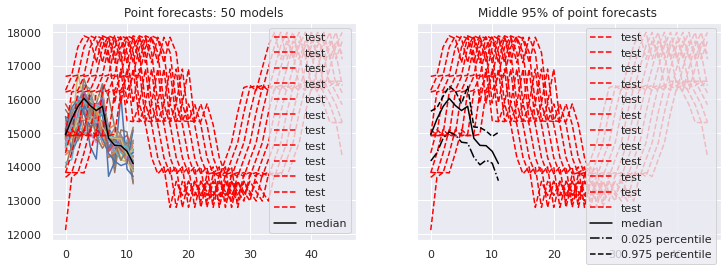

In [686]:
#plot the individual forecasts and the median

fig,ax = plt.subplots(1, 2, sharey=True, figsize=(12, 4))
ax[0].plot(e_preds_tran)
ax[0].plot(scaler.inverse_transform(y_test), label='test', linestyle='--', 
         color='red')
ax[0].plot(y_preds_mdn, label='median', linestyle='-', color='black')
ax[0].legend()
ax[0].set_title(f'Point forecasts: {N_MODELS} models')

ax[1].plot(scaler.inverse_transform(y_test), label='test', linestyle='--', 
         color='red')
ax[1].plot(y_preds_mdn, label='median', linestyle='-', color='black')
ax[1].plot(y_preds_2_5, label='0.025 percentile', linestyle='-.', color='black')
ax[1].plot(y_preds_97_5, label='0.975 percentile', linestyle='--', color='black')
#ax[1].plot(y_preds_lm, label='original lmforecast', linestyle='--', color='green')
ax[1].set_title(f'Middle 95% of point forecasts ')
ax[1].legend();

In [467]:
rmse_lm = rmse(scaler.inverse_transform(y_test), y_preds_lm)[0]
rmse_mdn = rmse(scaler.inverse_transform(y_test), y_preds_mdn)[0]

print(f'rmse lm: {rmse_lm:.2f}\nrmse ensemble: {rmse_mdn:.2f}')

rmse lm: 232.65
rmse ensemble: 579.12


In [468]:
rmse_25 = rmse(scaler.inverse_transform(y_test), y_preds_25)[0]
rmse_75 = rmse(scaler.inverse_transform(y_test), y_preds_75)[0]
print(f'95% of linear models will have rmse between: {rmse_75:.2f} - {rmse_25:.2f}')

95% of linear models will have rmse between: 305.72 - 884.97


So were the original linear model results just a fluke due to the choice of seed?  
Let's try another seed to find out.

In [469]:
#set tensorflow random seed for repeatability
#try multiple seeds
tf.random.set_seed(1066)

N_EPOCHS = 100
es = EarlyStopping(monitor='val_loss', patience=10)

#compile the tf model
model_lm = get_linear_model(ws=12, metrics=['mae'])

#fit model silently
history = model_lm.fit(x=X_train, 
                    y=y_train, 
                    epochs=N_EPOCHS,
                    validation_data=(X_test, y_test),
                    verbose=0,
                    batch_size=32,
                    callbacks=[es])

rmse lm: 232.65
rmse lm2: 466.79


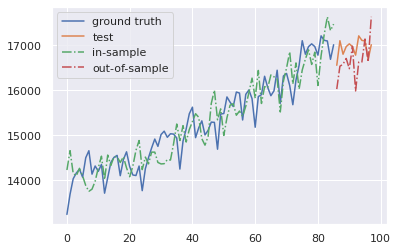

In [470]:
#predict next 12 months and plot
H = 12
y_preds_lm2 = autoregressive_iterative_forecast(model_lm, X_test[0], h=H)
y_preds_lm2 = scaler.inverse_transform(y_preds_lm2.reshape(-1, 1))

plot_nn_prediction_results(model_lm, X_train, y_train, y_test, y_preds_lm2)

rmse_lm = rmse(scaler.inverse_transform(y_test), y_preds_lm)[0]
rmse_lm2 = rmse(scaler.inverse_transform(y_test), y_preds_lm2)[0]

print(f'rmse lm: {rmse_lm:.2f}\nrmse lm2: {rmse_lm2:.2f}')

## Extra credit.
* How would you use a ensemble method with the direct forecasting method?